## LSTM 

In [59]:
import arff
import numpy as np
import pandas as pd
import math, time
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, concatenate, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [60]:
# read arff data
with open("EEG_Eye_State.arff") as f:
    # load reads the arff db as a dictionary with
    # the data as a list of lists at key "data"
    dataDictionary = arff.load(f)
    f.close()

In [61]:
# extract data and convert to numpy array
arffData = np.array(dataDictionary['data'])
#Assign colum names 
columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'Y']
df = pd.DataFrame(arffData,columns=[columns]).astype('float64')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0.0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0.0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0.0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0.0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0.0


In [62]:
df = df.apply(pd.to_numeric, errors='coerce')
df.dtypes

X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6     float64
X7     float64
X8     float64
X9     float64
X10    float64
X11    float64
X12    float64
X13    float64
X14    float64
Y      float64
dtype: object

In [63]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [64]:
#Get number of samples and number of features
df.shape

(14980, 15)

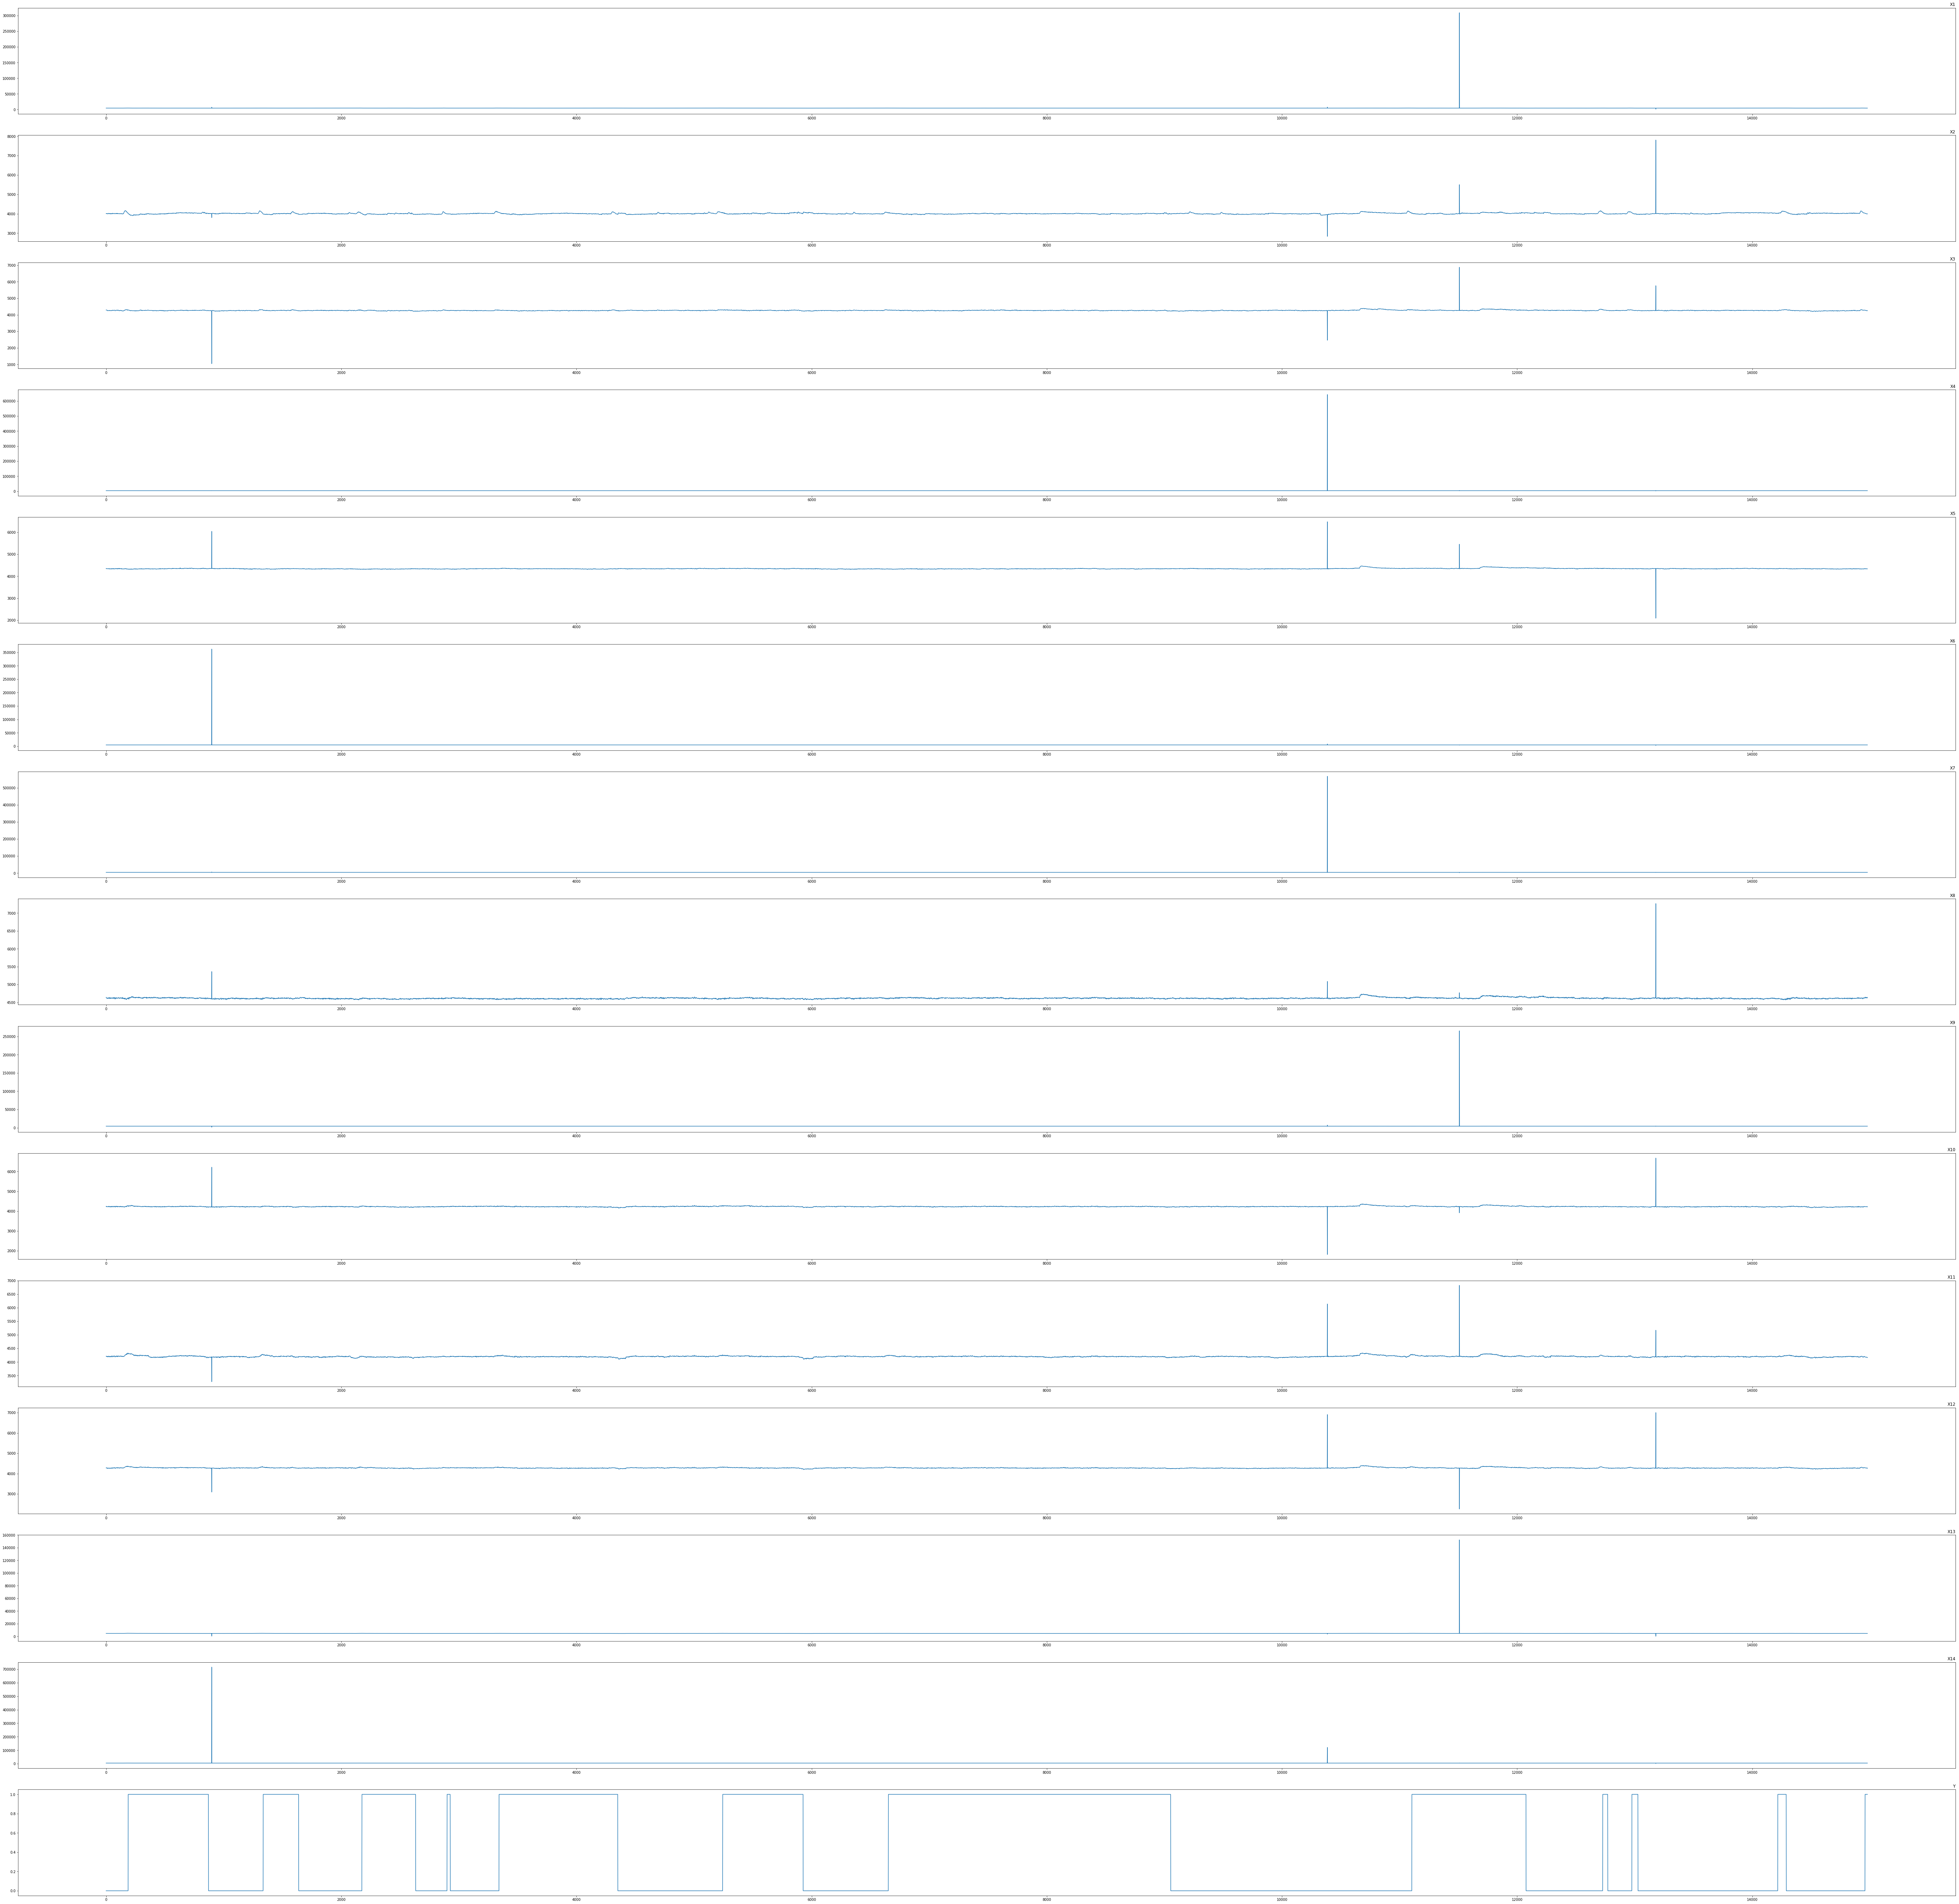

In [65]:
#Plot the Features
plt.rcParams["figure.figsize"] = (100,100)
for i in range(15):
    plt.subplot(15,1,i+1)
    dmin = df.iloc[:,i].min()
    dmax = df.iloc[:,i].max()
    dr = (dmax - dmin) * 0.7  # Crowd them a bit.
    y0 = dmin
    y1 = (df.iloc[:,i].count() - 1) * dr + dmax
    #plt.set_ylim(y0, y1)
    plt.plot(df.iloc[:,i])
    plt.title(columns[i],loc='right')
plt.show()

In [66]:
#remove missing values
df.dropna()
df.shape

(14980, 15)

In [67]:
#normalizing
scaler = MinMaxScaler(feature_range=(0,1))
scaled = df.copy()
scaled.iloc[:,0:14] = scaler.fit_transform(scaled.iloc[:,0:14])
scaled.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.010702,0.236931,0.556326,0.002648,0.515557,0.005053,0.003558,0.027383,0.010837,0.498575,0.264230,0.426286,0.029886,0.004237,0.0
1,0.010687,0.236004,0.557117,0.002649,0.513684,0.005054,0.003559,0.026619,0.010795,0.496148,0.263219,0.426071,0.029865,0.004224,0.0
2,0.010697,0.236416,0.557379,0.002661,0.512514,0.005046,0.003558,0.023390,0.010783,0.495197,0.262931,0.426610,0.029838,0.004231,0.0
3,0.010701,0.237446,0.557556,0.002660,0.514035,0.005043,0.003559,0.023579,0.010820,0.497940,0.264086,0.427799,0.029862,0.004241,0.0
4,0.010692,0.237446,0.556854,0.002653,0.514971,0.005054,0.003556,0.022437,0.010795,0.499735,0.264664,0.427909,0.029865,0.004244,0.0


In [68]:
#cleaning out outliers
for column in columns:
    if column == 'eyeDetection':
        continue
    scaled_cleaned = scaled.drop(scaled[scaled[column] < 0.95].index)

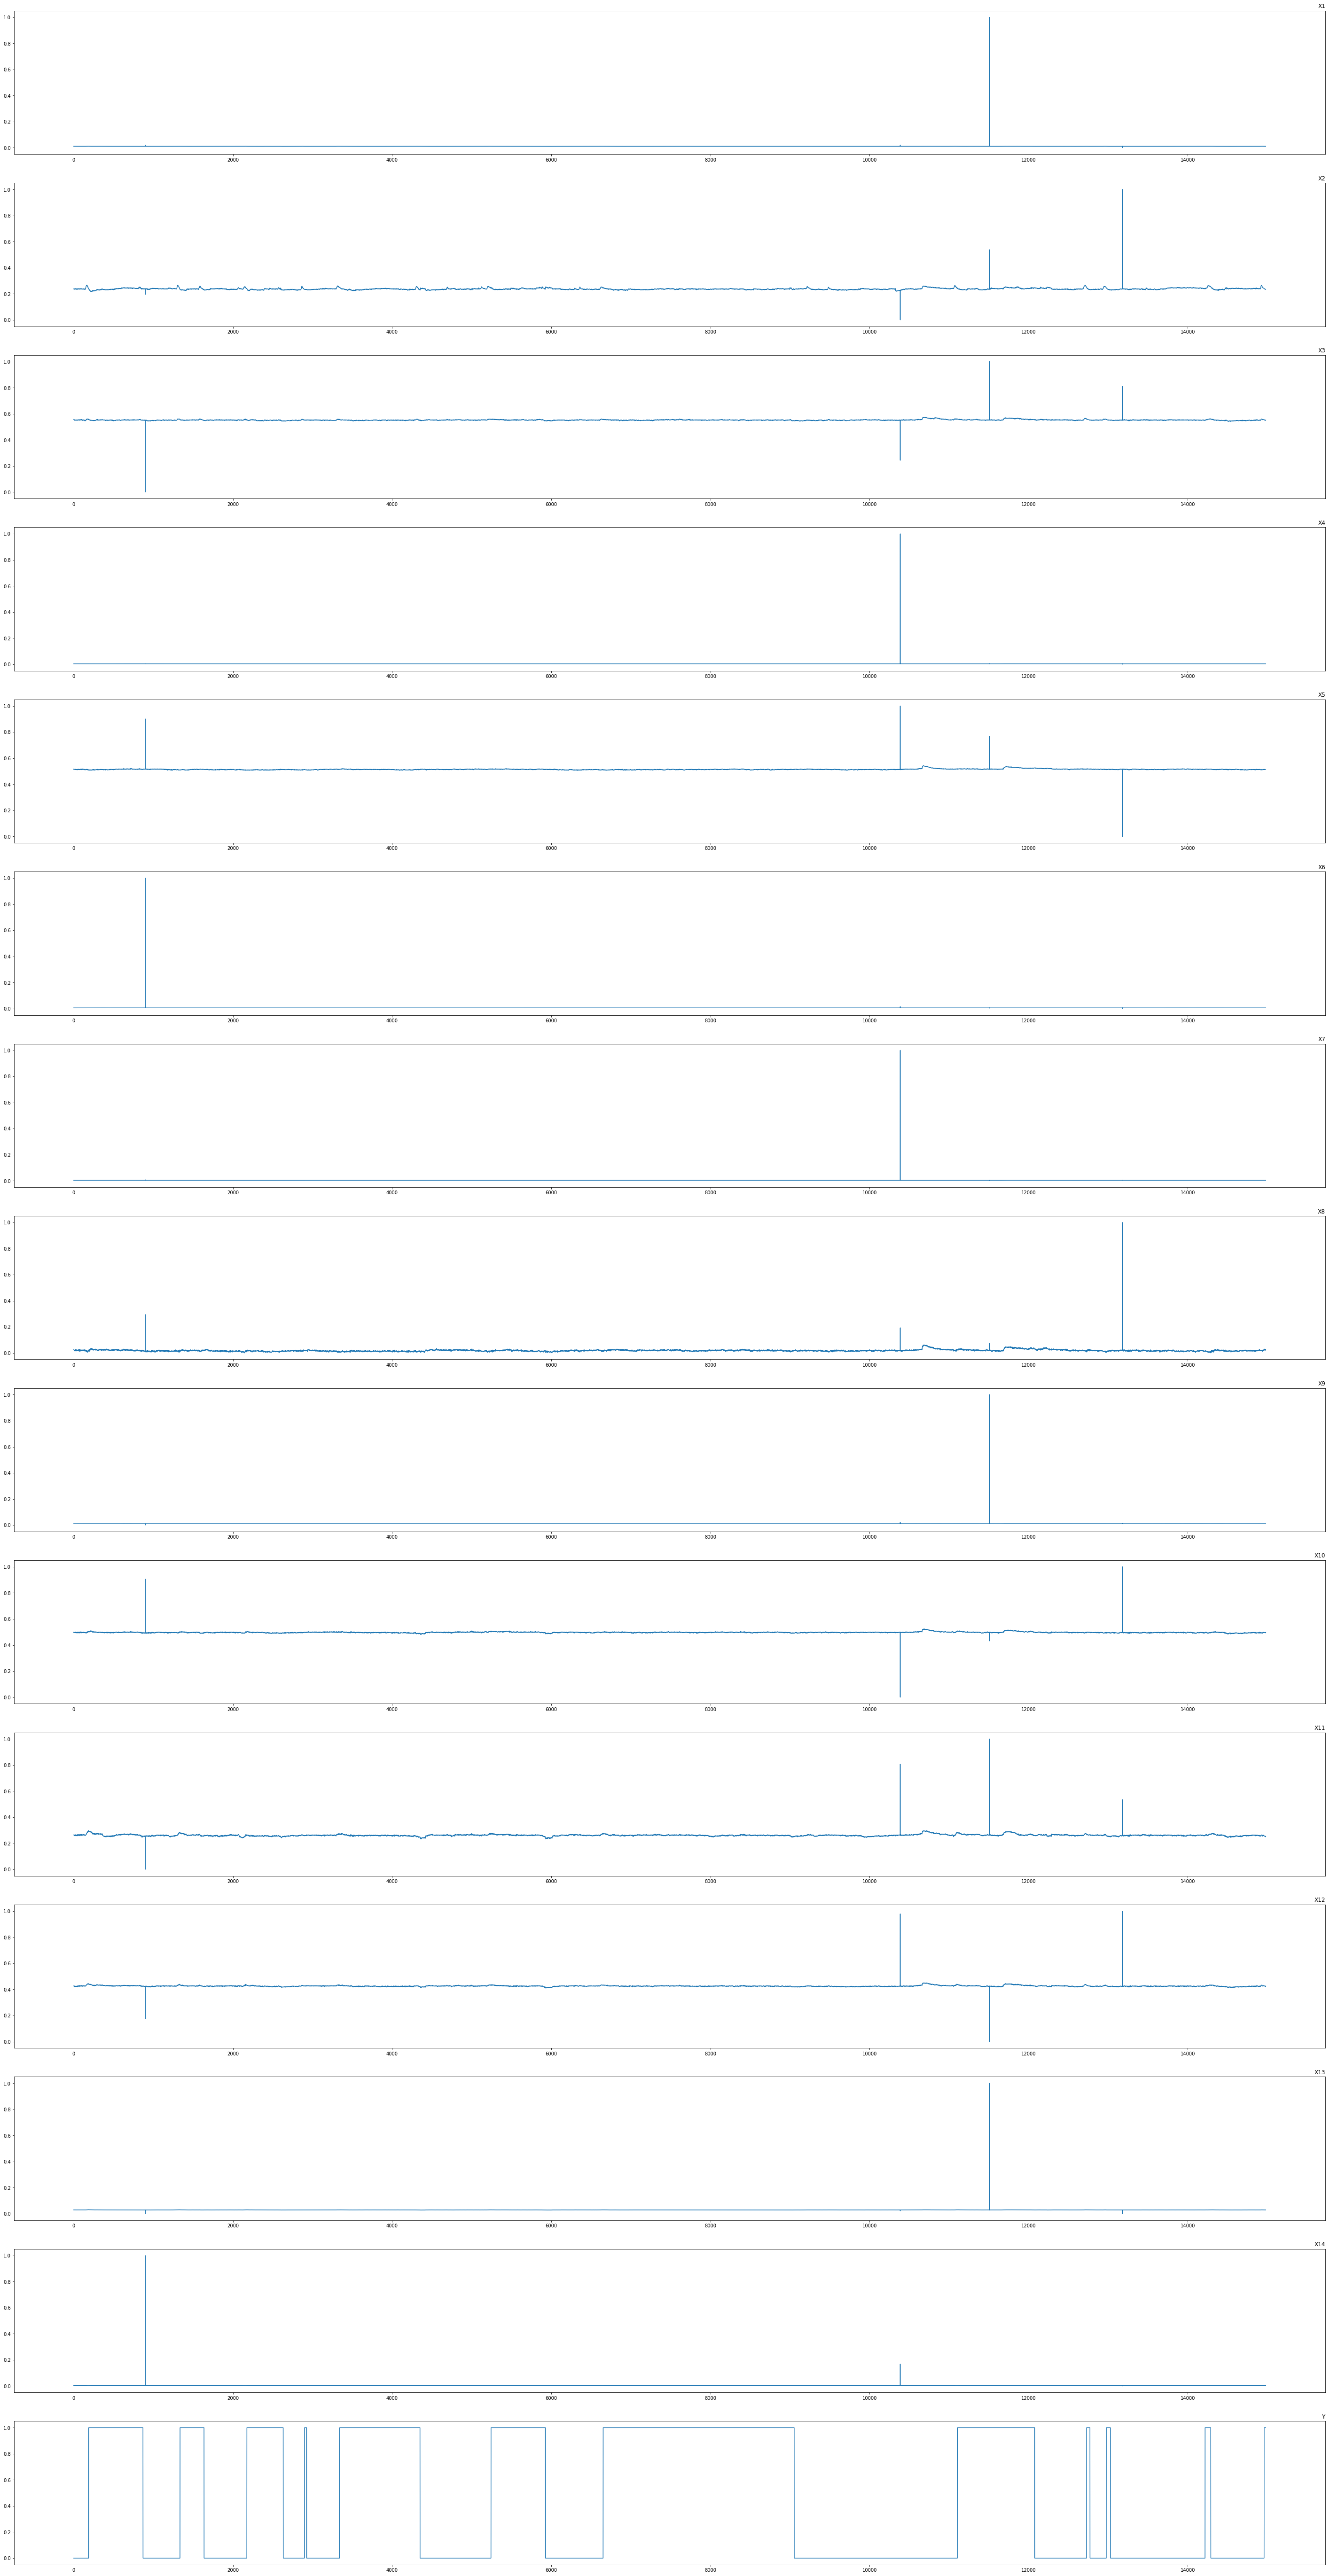

In [69]:
plt.rcParams["figure.figsize"] = (50,100)
for i in range(15):
    plt.subplot(15,1,i+1)
    plt.plot(scaled.iloc[:,i])
    plt.title(columns[i],loc='right')
plt.show()

In [70]:
scaled.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,0.010679,0.237039,0.552010,0.002674,0.513614,0.005214,0.003582,0.018123,0.010825,0.497104,0.261744,0.426017,0.029750,0.004269,0.448798
std,0.008086,0.009237,0.007607,0.008149,0.007923,0.008129,0.008142,0.010862,0.008084,0.007833,0.010645,0.008756,0.007938,0.008245,0.497388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010544,0.233220,0.549654,0.002585,0.511344,0.005124,0.003489,0.013883,0.010719,0.494880,0.258308,0.423584,0.029589,0.004165,0.000000
50%,0.010589,0.236209,0.551760,0.002605,0.512982,0.005141,0.003511,0.017112,0.010752,0.496675,0.261196,0.425529,0.029670,0.004183,0.000000
75%,0.010646,0.239716,0.553166,0.002623,0.514854,0.005165,0.003535,0.021106,0.010789,0.498787,0.264230,0.427692,0.029764,0.004208,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
def prepare_data(data, steps):  

    docX, docY = [], []
    #docX = []
    for i in range(len(data)-steps+1):
        docX.append(data.iloc[i:i+steps].as_matrix())
        docY.append(data.iloc[14].as_matrix())
    X_new = np.array(docX)
    Y_new = np.array(docY)

    return X_new, Y_new

In [72]:
#Features and target split for LSTM 1
X, Y =prepare_data(df,10)
X = X[:, :, :14]
Y = Y[: ,-1]
print(X.shape)
print(Y.shape)

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(14971, 10, 14)
(14971,)


In [73]:
#Features and target split for LSTM 2
X2, Y2 =prepare_data(df,10)
X2 = X2[:, :, :14]
Y2 = Y2[: ,-1]
print(X2.shape)
print(Y2.shape)

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(14971, 10, 14)
(14971,)


In [74]:
#print(X)
#print(Y)

In [75]:
from sklearn.model_selection import train_test_split

# create training and testing vars for LSTM1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(11976, 10, 14)
(11976,)
(2995, 10, 14)
(2995,)


In [76]:
from sklearn.model_selection import train_test_split

# create training and testing vars for LSTM 2
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2)
print(X_train2.shape)
print(Y_train2.shape)
print(X_test2.shape)
print(Y_test2.shape)

(11976, 10, 14)
(11976,)
(2995, 10, 14)
(2995,)


In [77]:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0,patience=5, verbose=1,mode='max'),
    ReduceLROnPlateau(factor=0.01, patience=8, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-eye-state.h5', verbose=1, save_best_only=True, save_weights_only=True),
]

# Model for LSTM1

In [78]:
model = Sequential()
model.add(LSTM(20, input_shape=(10, 14), return_sequences=True, implementation=2))
model.add(LSTM(10,return_sequences=False, input_shape=(None, 10, 14)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 20)            2800      
_________________________________________________________________
lstm_18 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 4,051
Trainable params: 4,051
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(loss="mse", optimizer='adam',metrics=['accuracy'])
results = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1,validation_split = 0.1,callbacks=callbacks)

Train on 10778 samples, validate on 1198 samples
Epoch 1/100
10778/10778 [==============================] - 5s 425us/step - loss: 0.0229 - acc: 0.9852 - val_loss: 4.3283e-04 - val_acc: 1.0000
Epoch 2/100
10778/10778 [==============================] - 3s 278us/step - loss: 2.1679e-04 - acc: 1.0000 - val_loss: 1.1891e-04 - val_acc: 1.0000
Epoch 3/100
10778/10778 [==============================] - 3s 276us/step - loss: 9.5301e-05 - acc: 1.0000 - val_loss: 7.6331e-05 - val_acc: 1.0000
Epoch 4/100
10778/10778 [==============================] - 3s 253us/step - loss: 6.2626e-05 - acc: 1.0000 - val_loss: 5.1301e-05 - val_acc: 1.0000
Epoch 5/100
10778/10778 [==============================] - 3s 255us/step - loss: 4.4259e-05 - acc: 1.0000 - val_loss: 3.9682e-05 - val_acc: 1.0000
Epoch 6/100
10778/10778 [==============================] - 3s 256us/step - loss: 3.5828e-05 - acc: 1.0000 - val_loss: 3.2438e-05 - val_acc: 1.0000
Epoch 00006: early stopping


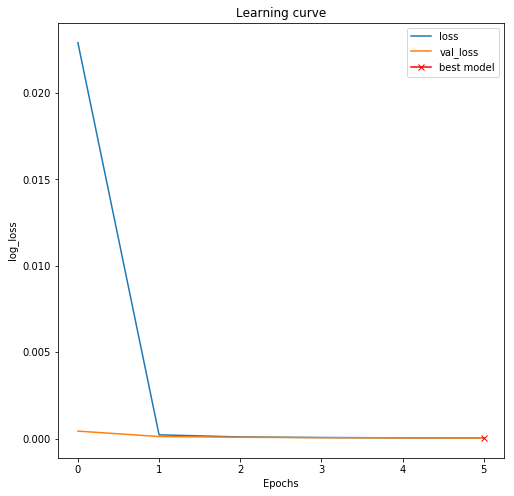

In [80]:
#ploting validation errror vs loss 
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [81]:
#summery
model.load_weights('model-eye-state.h5')
Y_Pred = model.predict(X_test)

def model_F_score(newp,newy_test):
    TP=0
    FN=0
    FP=0
    for i in range(len(newp)-1):
        test_prof=newy_test[i+1]-newy_test[i]
        p_prof=newp[i+1] - newp[i]

        if((test_prof>=0) and (p_prof>=0)):
            TP=TP+1
        if ((test_prof>= 0) and (p_prof<0)):
            FN=FN+1
        if ((test_prof<0) and (p_prof>=0)):
            FP=FP+1

    Precision=float(TP)/float(TP+FP)
    Recall=float(TP)/float(TP+FN)

    Fscore= 2.0*Precision*Recall/(Precision+Recall)
    print('classification F score: %.5f' % (Fscore))
    return Fscore
    
testScore = math.sqrt(mean_squared_error(Y_Pred, Y_test))
print('Test Score: %.2f RMSE' % (testScore))

F_score=model_F_score(Y_Pred,Y_test)
print ('F_score',F_score)

import matplotlib.pyplot as plt2

plt2.plot(Y_Pred,color='red', label='Prediction')
plt2.plot(Y_test,color='blue', label='Actual')
plt2.text(125,95,'F score %0.2f'% F_score,color='green')
plt2.legend(loc='best')
png_name='_win' + str(10) + '_e' + str(100) + '_bat' + str(32) +'.png'
plt2.savefig(png_name, dpi=75)
plt2.show()

Test Score: 0.01 RMSE
classification F score: 0.99833
F_score 0.998327199732352


ValueError: Image size of 2843x52146544 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3600x7200 with 1 Axes>

# Model for LSTM 2

In [82]:
#reshape Y
#Y2 = np.reshape(Y2, (1498, 10, 1))

In [83]:
model = Sequential()
model.add(LSTM(20, input_shape=(10, 14), return_sequences=True, implementation=2))
model.add(LSTM(10,return_sequences=False, input_shape=(None, 10, 14)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10, 20)            2800      
_________________________________________________________________
lstm_20 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 4,051
Trainable params: 4,051
Non-trainable params: 0
_________________________________________________________________


In [86]:

model.compile(loss="mse", optimizer='adam',metrics=['accuracy'])
results = model.fit(X_train2, Y_train2, epochs=100, batch_size=32, verbose=1,validation_split = 0.1,callbacks=callbacks)


Train on 10778 samples, validate on 1198 samples
Epoch 1/100
10778/10778 [==============================] - 5s 475us/step - loss: 4.4128e-06 - acc: 1.0000 - val_loss: 9.1795e-07 - val_acc: 1.0000
Epoch 2/100
10778/10778 [==============================] - 3s 305us/step - loss: 5.5640e-07 - acc: 1.0000 - val_loss: 3.5261e-07 - val_acc: 1.0000
Epoch 3/100
10778/10778 [==============================] - 3s 292us/step - loss: 2.6101e-07 - acc: 1.0000 - val_loss: 1.9298e-07 - val_acc: 1.0000
Epoch 4/100
10778/10778 [==============================] - 3s 286us/step - loss: 1.5334e-07 - acc: 1.0000 - val_loss: 1.2155e-07 - val_acc: 1.0000
Epoch 5/100
10778/10778 [==============================] - 3s 319us/step - loss: 1.0063e-07 - acc: 1.0000 - val_loss: 8.3056e-08 - val_acc: 1.0000
Epoch 6/100
10778/10778 [==============================] - 4s 341us/step - loss: 7.0595e-08 - acc: 1.0000 - val_loss: 5.9812e-08 - val_acc: 1.0000
Epoch 00006: early stopping


In [87]:
Y_Pred2 = model.predict(X_test2)

In [95]:
Y_Pred3 = []
for i in range (0,9):
    Y_Pred3[i] = model.predict(X_test2)

IndexError: list assignment index out of range